### Clone repo to access GPT2 weights

In [115]:
! git clone https://github.com/muxitox/nanoGPT.git

fatal: destination path 'nanoGPT' already exists and is not an empty directory.


In [116]:
%cd nanoGPT

/home/apoc/Documents/projects/nanoGPT/simple_model/nanoGPT/nanoGPT/nanoGPT/nanoGPT/nanoGPT


/home/apoc/Documents/projects/nanoGPT/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Imports

In [117]:
import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F
from model import GPTConfig, GPT

import matplotlib.pyplot as plt
import time

In [118]:
!pip install ipdb
import ipdb


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


### Utils

In [119]:
def bitfield(n, size):  # Transform positive integer into bit array
    x = [int(x) for x in bin(int(n))[2:]]
    x = [0] * (size - len(x)) + x
    return torch.array(x)

In [120]:
def qr_invert(A):

    Q, R = torch.linalg.qr(A)        # full QR for square A

    B = Q.T

    A_inv = torch.linalg.solve_triangular(R, B, upper=True)

    return A_inv

#### Plotting

In [121]:
def return_subplot(num_feats):
    if num_feats == 1:
        fig, ax = plt.subplots(1, 1)
    elif num_feats == 2:
        fig, ax = plt.subplots(2, 1)
    elif num_feats == 3:
        fig, ax = plt.subplots(3, 1)
    else:
        fig, ax = plt.subplots(min(4, math.floor((num_feats)/2)), 2)

    return fig, ax

In [122]:
def subplot_trajectories(stats, label, line, title, domain_label, random_feats=False, max_feats_show=4):

    T, num_feats = stats[0].shape
    num_feats_show = min(num_feats, max_feats_show)

    fig, ax = return_subplot(num_feats_show)
    ax = ax.ravel()

    if max_feats_show > 4 and random_feats:
        feats = torch.randperm(stats[0].shape[1])[:num_feats_show]
    else:
        feats = torch.arange(num_feats_show)

    for i in range(0, num_feats_show):
        for s in range(len(stats)):
            ax[i].plot(stats[s][:,feats[i]], line[s], label=label[s])

            ax[i].set_ylabel(f"${domain_label}_{{{feats[i]}}}$")
            ax[i].set_xlabel(f"$t$")

        if i==num_feats_show - 1:
            ax[i].legend()
    plt.suptitle(title)

### Forward functions for the network

In [123]:
def forward(x_vocab_next, x_prev, W_k, W_q, beta=1.0):
    # apply softmax to get probabilities
    k_vocab_next = x_vocab_next @ W_k.T
    q_prev = x_prev @ W_q.T
    Wk_Wq_x_prev = W_k.T @ q_prev  # Compute this also for comparison

    probs_next = F.softmax(beta * k_vocab_next @ q_prev, dim=0)

    # sample from the distribution
    idx_next = torch.multinomial(probs_next, num_samples=1)

    tok_next = x_vocab_next[idx_next][0]

    return tok_next, idx_next, Wk_Wq_x_prev, q_prev, probs_next

# Same but with q instead of x_t and W_q
def forward_q(x_vocab_next, q_prev, W_k, beta=1.0):
    # apply softmax to get probabilities
    k_vocab_next = x_vocab_next @ W_k.T

    probs_next = F.softmax(beta * k_vocab_next @ q_prev, dim=0)

    # sample from the distribution
    idx_next = torch.multinomial(probs_next, num_samples=1)

    tok_next = x_vocab_next[idx_next][0]

    return tok_next, idx_next, probs_next

In [155]:
def forward_mf(x_vocab_next, mu_k_vocab, sigma_k_vocab, mu_q_prev, sigma_q_prev, W_k, W_q, beta):

    # Compute k and mu_tilde
    k_vocab_next = beta * x_vocab_next @ W_k.T
    sigma_q_prev_inv = qr_invert(sigma_q_prev)
    # $ \bm {\tilde{\mu}} =   \bm \mu^k  - (\beta \bm \Sigma^{q} )^{-1} \bm \mu_q  $
    mu_tilde = beta * mu_k_vocab - mu_q_prev @ sigma_q_prev_inv
    k_centered_tilde = k_vocab_next - mu_tilde

    # Compute C
    C = sigma_q_prev_inv + beta**2 * sigma_k_vocab
    C_inv = qr_invert(C)
    p_x_next = torch.einsum('ni,ij,nj->n', k_centered_tilde, C_inv, k_centered_tilde) / 2

    print("mu_k_vocab", mu_k_vocab)
    print("sigma_q_prev", sigma_q_prev)
    print("sigma_q_prev_inv", sigma_q_prev_inv)
    print("mu_tilde", mu_tilde)
    print("k_centered_tilde", k_centered_tilde)
    print("C_inv", C_inv)
    print("px_next", p_x_next)

    p_x_next = F.softmax(p_x_next, dim=0)

    # Get the mean of x
    mu_x_next = torch.sum(p_x_next[:, None] * x_vocab_next, dim=0)

    mu_k_next = mu_x_next @ W_k.T
    mu_q_next = mu_x_next @ W_q.T

    q_next = x_vocab_next @ W_q.T
    q_centered_next = q_next - mu_q_next
    sigma_q_next = torch.einsum('n,nm,nk->mk', p_x_next, q_centered_next, q_centered_next)

    return mu_k_next, mu_q_next, sigma_q_next, p_x_next

In [149]:
def forward_mf_0(x_vocab_next, q_0, W_k, W_q, beta):

    # Compute the probability of the text token
    k_vocab_next = x_vocab_next @ W_k.T


    p_x_next = F.softmax(beta * k_vocab_next @ q_0, dim=0)

    # Get the mean of x
    mu_x_next = torch.sum(p_x_next[:, None] * x_vocab_next, dim=0)

    mu_k_next = mu_x_next @ W_k.T
    mu_q_next = mu_x_next @ W_q.T

    q_next_vocab = tok_emb @ W_q.T
    q_centered_next = q_next_vocab - mu_q_next
    sigma_q_next = torch.einsum('n,nm,nk->mk', p_x_next, q_centered_next, q_centered_next)


    return mu_k_next, mu_q_next, sigma_q_next, p_x_next

### Experiment settings

In [126]:
num_trials = 10000
num_running_steps = 5

timesteps_to_examine = [0, 1, 2, 3, 4] # For debugging purposes

### Network settings

In [159]:
beta = 1.0
binary_vars = False
q_is_roll = True  # If W_q a shift over W_k
patterns_from_vocab = True # If you draw samples from the token vocab to make the W patterns
emb_size = 5000 # Number of tokens in the embedding. -1 if you want the full vocab size
num_patterns = 3  # Number of patterns in the W matrices. -1 if you want to match token_size
token_size = 750 # Number of features. If -1, match with the embedding token size, otherwise, force your selection.
random_ini_token = False
ini_token_idx = 1
# prev seed  150, 158
seed = 250

torch.manual_seed(seed)


In [160]:
device = 'cpu'  # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.

if not binary_vars:

    # In this case instead of initializing from random varialbes, use GPT2 embeddings
    # as initialization (They are distributed in a Gaussian way for a large number of tokens).

    # Load GPT2
    model_name = "gpt2"
    model = GPT.from_pretrained(model_name, dict(dropout=0.0))
    model.to(device)

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M


In [161]:
####################
# Set up the vocabulary and weights
####################

# Define the tokens or spins
if binary_vars:    # Binary variables

    if token_size == -1:
        raise Exception("token_size must be defined")
    if num_patterns == -1:
        raise Exception("num_patterns must be defined")
    if emb_size == -1:
        raise Exception("emb_size must be defined")

    tok_emb = (torch.rand((emb_size, token_size), device=device) > 0.5).float()
    tok_emb = tok_emb * 2 - 1
else:   # Tokens from GPT2

    # Get embeddings to sample tokens from them
    wte = model.transformer.wte
    num_embeddings = wte.num_embeddings

    if token_size==-1:
        token_size = wte.embedding_dim

    if emb_size == -1:
      emb_size = num_embeddings

    if num_patterns == -1:
      num_patterns = token_size

    # Select emb_size tokens from the embedding to create a smaller vocabulary
    perm_tokens_idxs = torch.randperm(num_embeddings)
    tokens_idxs = perm_tokens_idxs[:emb_size]

    # Transform into token representation
    # Equivalent to x_{t+1} in the LaTeX doc
    tok_emb = model.transformer.wte(tokens_idxs).detach()
    perm_feats_idxs = torch.randperm(wte.embedding_dim)
    tok_emb = tok_emb[:, perm_feats_idxs[:token_size]]

# Define the W patterns

if patterns_from_vocab:

    if num_patterns > emb_size:
        raise Exception("num_patterns > emb_size")

    k_patts = torch.randperm(emb_size)[:num_patterns]
    # q_patts = torch.randperm(emb_size)[:num_patterns]
    q_patts = torch.randperm(num_patterns)

    # counter = 0
    # while(torch.equal(k_patts, q_patts) and (counter < 10)):
    #     q_patts = torch.randperm(num_patterns)
    #     counter = counter + 1

    W_k = tok_emb[k_patts]
    # W_q = tok_emb[q_patts]
    W_q = W_k[q_patts]

    if binary_vars:
        W_k = W_k / math.sqrt(token_size)
        W_q = W_q / math.sqrt(token_size)
    else:

        tok_mean = torch.mean(tok_emb, dim=None)
        tok_mean_b = torch.mean(tok_emb, dim=0)
        k_mean = torch.mean(tok_emb[k_patts], dim=None)
        q_mean = torch.mean(tok_emb[q_patts], dim=None)
        k_std = torch.std(tok_emb[k_patts], dim=None)
        q_std = torch.std(tok_emb[q_patts], dim=None)

        tok_emb_std = torch.std(tok_emb, dim=None)
        tok_emb_std_b = torch.std(tok_emb, dim=0)

        scaling = torch.sqrt(tok_emb_std_b**2 + tok_mean_b**2)
        # FPC = 1 - (num_patterns / emb_size)
        # W_k = tok_emb[k_patts] / scaling
        # W_q = tok_emb[q_patts] / scaling
        #
        # J = (1 / math.sqrt(token_size * num_patterns)) * (W_k.T @ W_q)

        W_k = W_k / (scaling * (token_size * num_patterns)**(1/4))
        W_q = W_q / (scaling * (token_size * num_patterns)**(1/4))


    J = (W_k.T @ W_q)
    J_var = torch.var(J, dim=None)
    print("J variance", J_var, 1/token_size)
    print()

else:
    # Create random W patterns
    w_mean = 0
    # w_std = 1/math.sqrt(token_size)
    w_std = 1
    # num_patterns = token_size
    W_k = torch.normal(w_mean, w_std, (num_patterns, token_size))
    W_q = torch.normal(w_mean, w_std, (num_patterns, token_size))

    if binary_vars and not patterns_from_vocab:
        raise Exception("Behavior not programmed yet")

if q_is_roll:
    W_q = torch.roll(W_k, 1, 0)


J variance tensor(0.0012) 0.0013333333333333333



### Choose initial token

In [162]:
# Choose initial token
# Choose x_0
if random_ini_token:
    tok_0 = torch.randn((emb_size, token_size))[ini_token_idx]
else:
    # tok_0 = tok_emb[ini_token_idx]
    tok_0 = W_q[ini_token_idx]


### For debugging purposes

In [163]:
timesteps_to_examine = [t for t in timesteps_to_examine if t < num_running_steps]
# With this dict we'll be able to index the proper timesteps.
timesteps_to_examine_dict = dict([(k,v) for k, v in zip(timesteps_to_examine, range(len(timesteps_to_examine)))])

# Not used atm because we are averaging. Only for use in simulations
# Create structure to save data from different runs
n_trials_to_examine = [1, 3]
n_trials_to_examine = [r for r in n_trials_to_examine if r < num_running_steps]
n_trials_to_examine_dict = dict([(k,v) for k, v in zip(n_trials_to_examine, range(len(n_trials_to_examine)))])

## Simulation. Model without approximation

In [164]:

################################################
# Compute the average over multiple trajectories (without approximation)
################################################

def simulate(beta):

    # Variables to save statistics
    tok_stats_sim = torch.zeros((num_trials, num_running_steps, token_size))
    idxs = torch.zeros((num_trials, num_running_steps))
    probs_sim_t_mean = torch.zeros((num_running_steps, emb_size))


    startt = time.time()
    for r in range(num_trials):

        # if r % 100 == 0:
        #     print(f"Trial {r+1}/{num_trials}")

        tok_prev = tok_0.clone()
        for t in range(num_running_steps):

            # Get the next token
            tok_prev, idx_prev, Wk_Wq_x_prev_2, q_prev_2, probs_prev = forward(tok_emb, tok_prev, W_k, W_q, beta)

            # Accumulate stats
            tok_stats_sim[r, t, :] += tok_prev
            idxs[r, t] = idx_prev
            probs_sim_t_mean[t, :] = probs_sim_t_mean[t, :] + probs_prev

    probs_sim_t_mean /= num_trials

    endt = time.time()
    time_elapsed = endt - startt
    print(f"Simulation. Time elapsed: {time_elapsed:.2f} seconds")

    return tok_stats_sim, idxs, probs_sim_t_mean

In [165]:
tok_stats_sim, idxs, probs_sim_t_mean = simulate(beta)

print("Selected tokens at each step")
print(idxs[0])
print(idxs[3])
print(idxs[100])
print(idxs[-1])

mode_idxs = torch.mode(idxs, 0).values
tok_stats_sim_avg = torch.mean(tok_stats_sim, dim=0)

Simulation. Time elapsed: 44.20 seconds
Selected tokens at each step
tensor([4452.,  339.,  449., 4452.,  339.])
tensor([4452.,  339.,  449., 4452.,  339.])
tensor([4452.,  339.,  449., 4452.,  339.])
tensor([4452.,  339.,  449., 4452.,  339.])


In [166]:
stats_k_sim = tok_stats_sim_avg @ W_k.T
stats_k_sim

tensor([[ 0.2483,  5.7010,  1.0264],
        [ 3.6541,  1.0260, 15.4482],
        [18.1924,  0.2485,  3.6527],
        [ 0.2483,  5.7010,  1.0275],
        [ 3.6544,  1.0259, 15.4510]])

## Model with approximation

In [168]:
#####
# Compute the approximation
########

def simulate_mf(beta, mu_k_vocab, sigma_k_vocab, tok_0):

    # Variables to save stats
    stats_k_mf = torch.zeros((num_running_steps, num_patterns))
    idxs_mf = torch.zeros(num_running_steps)

    probs_mf_t = torch.zeros(len(timesteps_to_examine), emb_size)
    q_mf_t = torch.zeros(num_running_steps, num_patterns)
    q_mf_cov_t = torch.zeros(num_running_steps, num_patterns, num_patterns)

    # Start conditions
    q_0 = tok_0 @ W_q.T

    for t in range(0, num_running_steps):

        print(t)
        if t == 0:
            # First iteration without Gaussian approx for q
            mu_k_prev, mu_q_prev, sigma_q_prev, p_x_prev = forward_mf_0(tok_emb, q_0, W_k, W_q, beta)
            print("here")
        else:
            mu_k_prev, mu_q_prev, sigma_q_prev, p_x_prev = forward_mf(tok_emb, mu_k_vocab, sigma_k_vocab, mu_q_prev, sigma_q_prev, W_k, W_q, beta)
            print("there")

        print("mu_k", mu_k_prev)
        print("sum p_x", p_x_prev.sum(dim=0))
        print()
        # Save stats
        stats_k_mf[t] = mu_k_prev
        if t in timesteps_to_examine:
            probs_mf_t[timesteps_to_examine_dict[t]] = p_x_prev
            q_mf_t[t] = mu_q_prev
            q_mf_cov_t[t] = sigma_q_prev

    print("MF")
    return stats_k_mf, idxs_mf, probs_mf_t, q_mf_t, q_mf_cov_t



In [169]:
# Compute sufficient statistics for k
# Get mean and covariances from the vocabulary for the approximation
# For x
tok_emb_mu = torch.mean(tok_emb, dim=0)
tok_emb_cov = torch.cov((tok_emb).T)


# For k it's faster just projecting the statistics by the linearity
mu_k = tok_emb_mu @  W_k.T
cov_k =  W_k @ tok_emb_cov @ W_k.T

In [170]:
stats_k_mf, idxs_mf, probs_mf_t, q_mf_t, q_mf_cov_t = simulate_mf(beta, mu_k, cov_k, tok_0)

0
here
mu_k tensor([0.2480, 5.7015, 1.0260])
sum p_x tensor(1.)

1
mu_k_vocab tensor([3.0561, 1.1054, 2.8923])
sigma_q_prev tensor([[ 1.2790e-13, -2.6645e-14, -8.5265e-13],
        [-2.6645e-14,  5.5512e-15,  1.7764e-13],
        [-8.5265e-13,  1.7764e-13,  5.6843e-12]])
sigma_q_prev_inv tensor([[-2.6929e+20,  6.1901e+19, -4.2328e+19],
        [ 3.6468e+19, -9.8102e+17,  5.5008e+18],
        [-4.1533e+19,  9.3158e+18, -6.5211e+18]])
mu_tilde tensor([ 5.0405e+20, -1.1638e+20,  7.9245e+19])
k_centered_tilde tensor([[-5.0405e+20,  1.1638e+20, -7.9245e+19],
        [-5.0405e+20,  1.1638e+20, -7.9245e+19],
        [-5.0405e+20,  1.1638e+20, -7.9245e+19],
        ...,
        [-5.0405e+20,  1.1638e+20, -7.9245e+19],
        [-5.0405e+20,  1.1638e+20, -7.9245e+19],
        [-5.0405e+20,  1.1638e+20, -7.9245e+19]])
C_inv tensor([[ 1.9259e-14, -4.0123e-15, -1.2839e-13],
        [-4.0123e-15,  8.3603e-16,  2.6749e-14],
        [-1.2839e-13,  2.6749e-14,  8.5595e-13]])
px_next tensor([-7.0375e+20

In [171]:
stats_k_mf

tensor([[ 0.2480,  5.7015,  1.0260],
        [ 3.0561,  1.1054,  2.8923],
        [18.1942,  0.2480,  3.6530],
        [ 3.0561,  1.1054,  2.8923],
        [18.1942,  0.2480,  3.6530]])

In [172]:
stats_k_sim

tensor([[ 0.2483,  5.7010,  1.0264],
        [ 3.6541,  1.0260, 15.4482],
        [18.1924,  0.2485,  3.6527],
        [ 0.2483,  5.7010,  1.0275],
        [ 3.6544,  1.0259, 15.4510]])

In [173]:
q_mf_cov_t[3]

tensor([[ 0.5476,  0.2424, -0.0396],
        [ 0.2424,  0.6991, -0.0826],
        [-0.0396, -0.0826,  0.0704]])

## Plotting

In [180]:
print(probs_sim_t_mean[1, :], max(probs_sim_t_mean[1, :]))
print(probs_mf_t[1, :], max(probs_mf_t[1, :]))

tensor([2.5316e-30, 9.4398e-31, 4.2070e-28,  ..., 8.2883e-33, 2.3930e-33,
        3.4419e-30]) tensor(0.9999)
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]) tensor(0.0002)


In [179]:
probs_mf_t[timesteps_to_examine_dict[0]]

tensor([2.1418e-36, 7.1400e-35, 2.9011e-35,  ..., 1.9289e-34, 1.1511e-36,
        2.7046e-33])

True
tensor(1.) tensor(1.) tensor(1.)
False
tensor(0.9999) tensor(0.9999) tensor(0.0002)
False
tensor(1.) tensor(0.9999) tensor(1.)
False
tensor(0.9999) tensor(0.9999) tensor(0.0002)
False
tensor(1.) tensor(0.9999) tensor(1.)


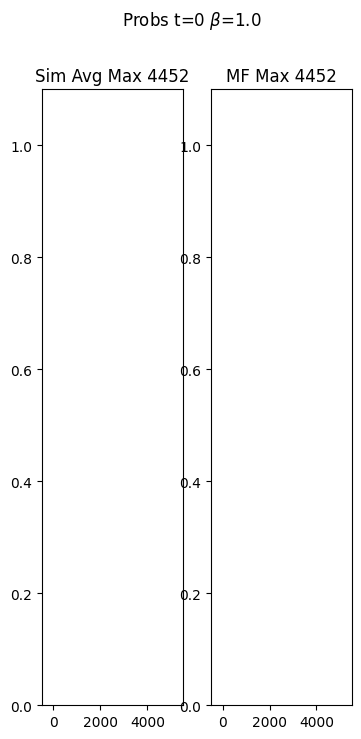

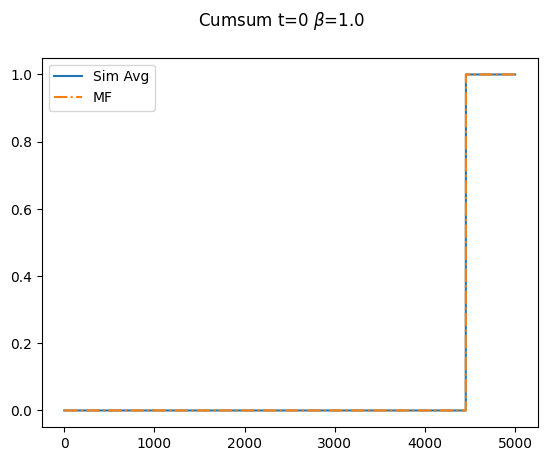

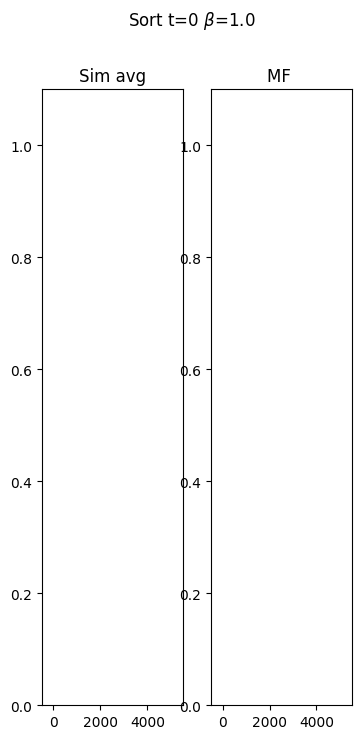

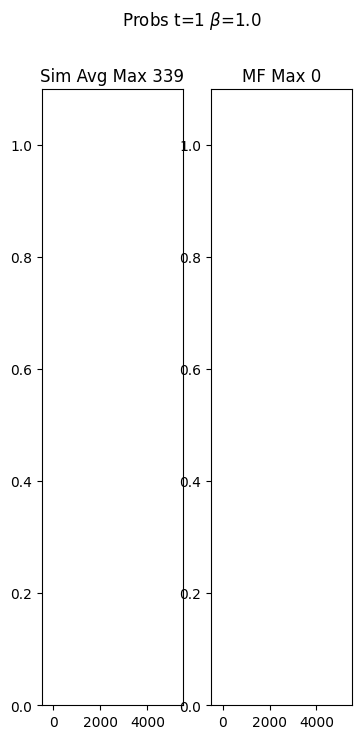

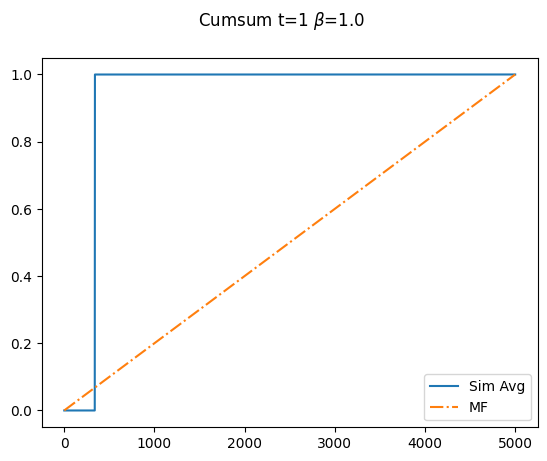

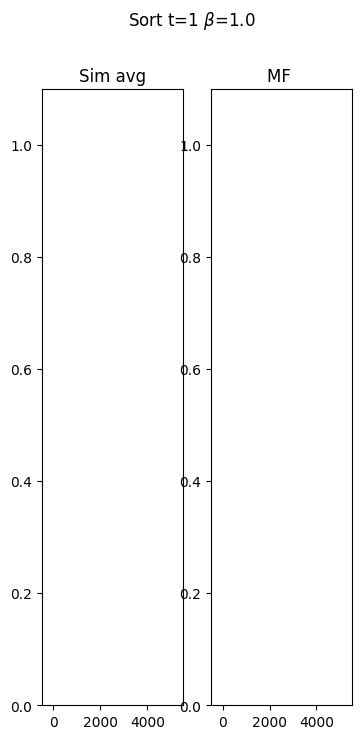

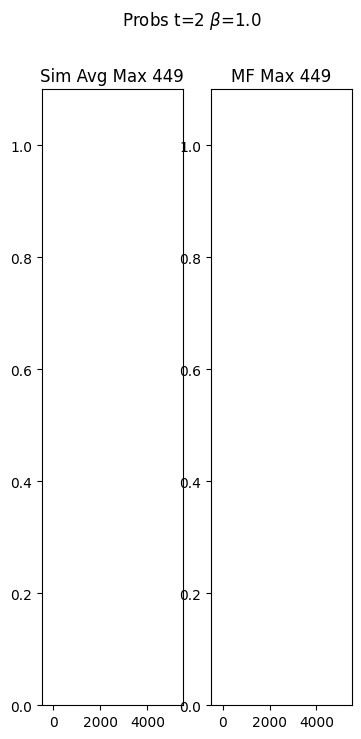

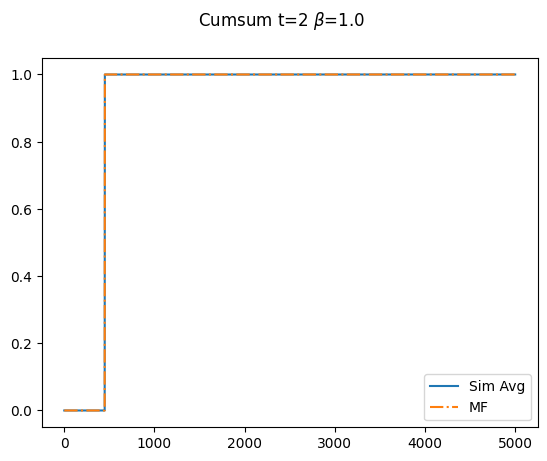

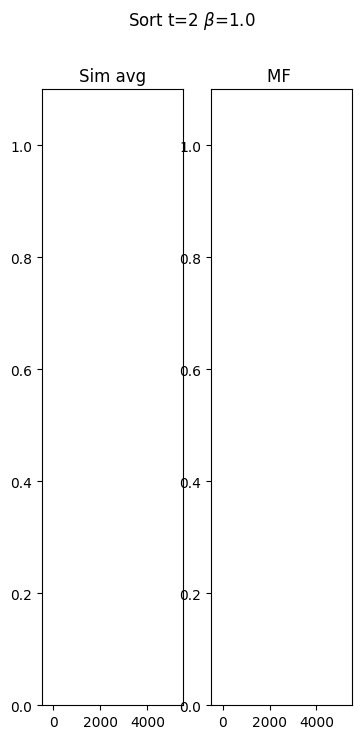

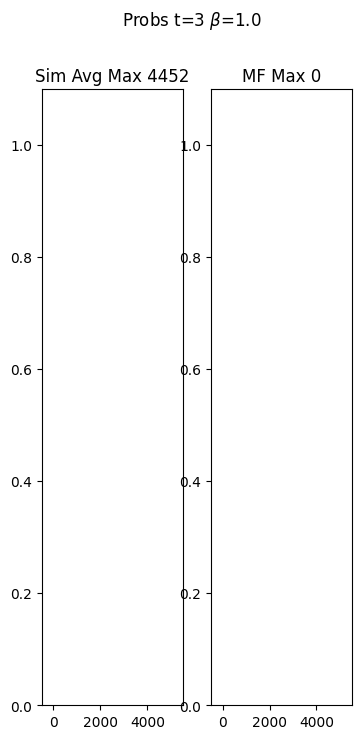

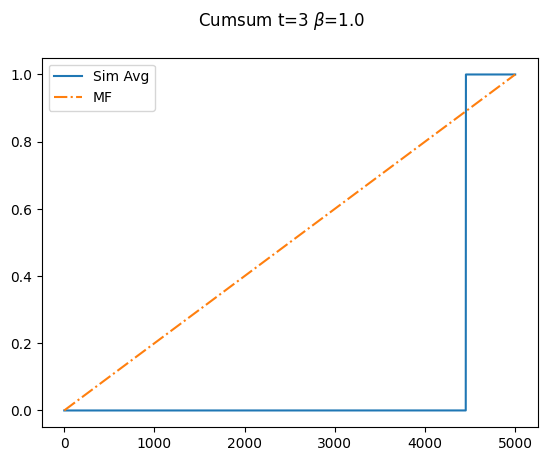

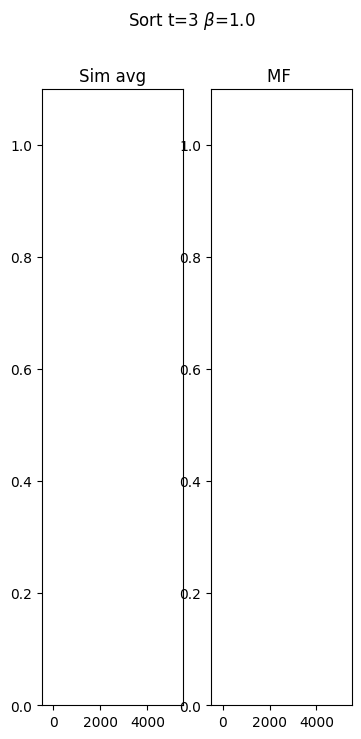

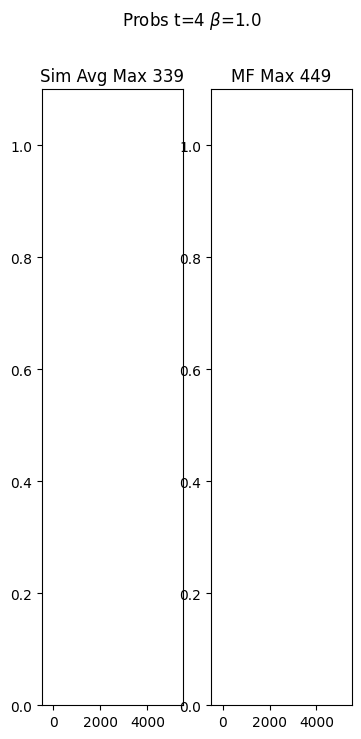

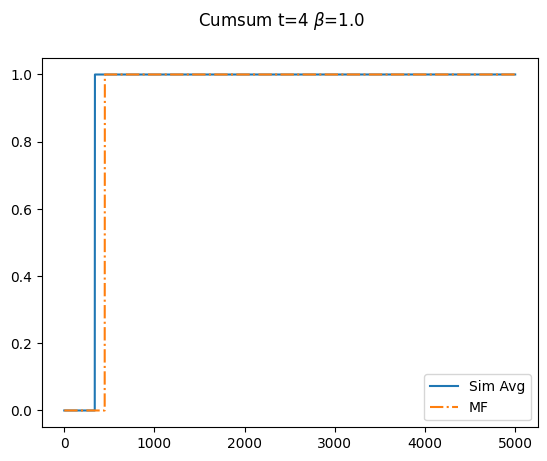

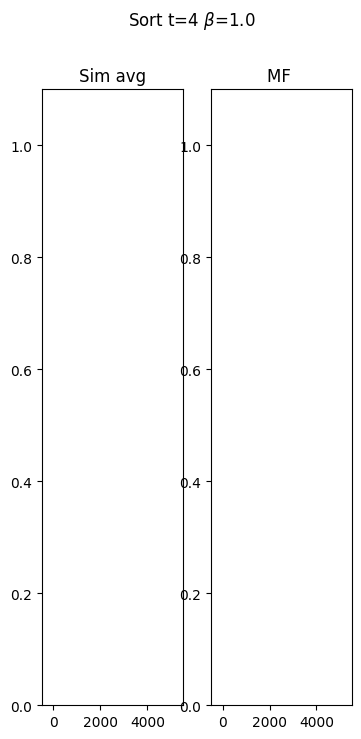

In [175]:
for t in range(len(timesteps_to_examine)):
    fig, ax = plt.subplots(1, 2, figsize=(4, 8))

    ax = ax.ravel()


    # Print stats about probabilities

    print(torch.allclose(probs_sim_t_mean[t, :], probs_mf_t[timesteps_to_examine_dict[t], :]))

    maxprob = torch.max(torch.cat((probs_sim_t_mean[t, :], probs_mf_t[timesteps_to_examine_dict[t], :])))

    print(maxprob, torch.max(probs_sim_t_mean[t :]), torch.max(probs_mf_t[timesteps_to_examine_dict[t], :]))

    hmargin = 0.1
    vmargin = 0.1
    bw = 2.1

    # Plot raw bar diagram for the probabilites' comparison
    ax[0].bar(torch.arange(emb_size).int(), probs_sim_t_mean[t, :], width=bw)
    ax[0].set_title(f"Sim Avg Max {torch.argmax(probs_sim_t_mean[t, :])}")
    ax[1].bar(torch.arange(emb_size).int(), probs_mf_t[timesteps_to_examine_dict[t], :], width=bw)
    ax[1].set_title(f"MF Max {torch.argmax(probs_mf_t[timesteps_to_examine_dict[t], :])}")

    for ax_i in ax:
        ax_i.set_ylim(0, maxprob + maxprob * vmargin)
        ax_i.set_xlim(0 - emb_size * hmargin, emb_size + emb_size * hmargin)
    plt.suptitle(rf"Probs t={t} $\beta$={beta}")

    # Plot cumsum
    plt.figure()
    plt.plot(torch.arange(emb_size), torch.cumsum(probs_sim_t_mean[t, :], dim=0), label="Sim Avg")
    plt.plot(torch.arange(emb_size), torch.cumsum(probs_mf_t[timesteps_to_examine_dict[t], :], dim=0), "-.", label="MF")
    plt.suptitle(rf"Cumsum t={t} $\beta$={beta}")
    plt.legend()

    # Plot ordered probabilities
    fig, ax = plt.subplots(1, 2, figsize=(4, 8))
    ax = ax.ravel()
    ax[0].bar(torch.arange(emb_size), torch.sort(probs_sim_t_mean[t, :], dim=0).values, width=bw)
    ax[0].set_title(f"Sim avg")
    ax[1].bar(torch.arange(emb_size), torch.sort(probs_mf_t[timesteps_to_examine_dict[t], :], dim=0).values, width=bw)
    ax[1].set_title(f"MF ")

    for ax_i in ax:
        ax_i.set_ylim(0, maxprob + maxprob * vmargin)
        ax_i.set_xlim(0 - emb_size * hmargin, emb_size + emb_size * hmargin)

    plt.suptitle(rf"Sort t={t} $\beta$={beta}")


In [116]:
 t_explore = 3
 print(torch.sum(torch.sort(probs_sim_t_run[0, t_explore, :], dim=0).values))
 print(torch.sort(probs_sim_t_run[0, t_explore, :], dim=0).values)

tensor(1.)
tensor([9.1349e-39, 1.6359e-37, 4.8521e-37,  ..., 6.9391e-19, 4.5042e-15,
        1.0000e+00])


In [121]:
W_k

tensor([[ 0.1195, -0.0350, -0.1468,  ...,  0.0646,  0.0536, -0.2039],
        [ 0.0815,  0.0439, -0.0554,  ..., -0.0144, -0.0340, -0.0111],
        [ 0.0699, -0.0643, -0.1569,  ...,  0.0397, -0.0884,  0.0033]])

In [122]:
W_q

tensor([[ 0.1195, -0.0350, -0.1468,  ...,  0.0646,  0.0536, -0.2039],
        [ 0.0815,  0.0439, -0.0554,  ..., -0.0144, -0.0340, -0.0111],
        [ 0.0699, -0.0643, -0.1569,  ...,  0.0397, -0.0884,  0.0033]])

Plot just the average of the simulated trajectory

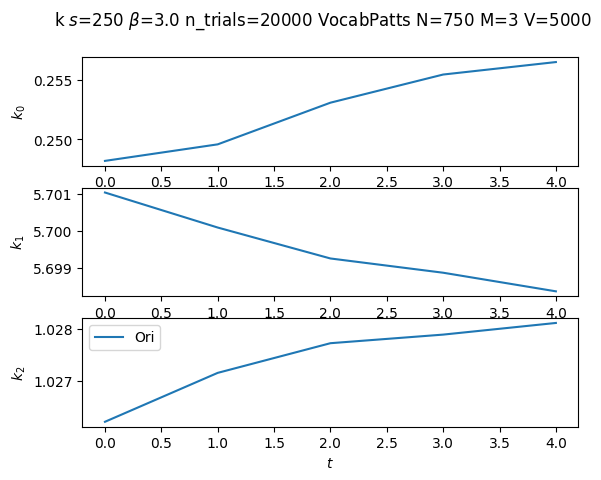

In [117]:
tag = "k"
if patterns_from_vocab:
    patterns_str = "VocabPatts"
else:
    patterns_str = "GaussianPatts"

stats = [tok_stats_sim_avg @ W_k.T]
# stats = [stat[num_patterns:num_patterns*3] for stat in stats]
label = ["Ori"]
line = ["-"]
title = rf"{tag} $s$={seed} $\beta$={beta} n_trials={num_trials} {patterns_str} N={token_size} M={num_patterns} V={emb_size}"
subplot_trajectories(stats, label, line, title, "k", random_feats=False, max_feats_show=3)

In [118]:
stats

[tensor([[0.2482, 5.7010, 1.0262],
         [0.2496, 5.7001, 1.0272],
         [0.2531, 5.6992, 1.0277],
         [0.2555, 5.6989, 1.0279],
         [0.2565, 5.6984, 1.0281]])]

Now compare with MF

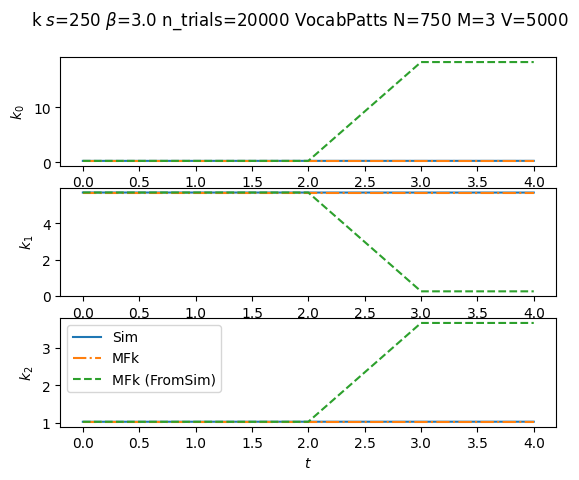

In [119]:
# stats = [tok_stats_sim_avg @ W_k.T,  stats_k_mf, stats_k_mf_m3, tok_stats_sim_avg_m4 @ W_k.T]
# label = ["Sim", "MFk", "MFk (FromSim)", "Sim (FromMF)"]
# line = ["-", "-.", "--", ":"]

stats = [tok_stats_sim_avg @ W_k.T,  stats_k_mf]
label = ["Sim", "MFk", "MFk (FromSim)"]
line = ["-", "-.", "--"]

subplot_trajectories(stats, label, line, title, "k", random_feats=True)

In [120]:
tok_stats_sim_avg_m4.shape

NameError: name 'tok_stats_sim_avg_m4' is not defined

Show the marginal distribution for the Gaussians of $q_t$ for the simulated and approximated model

t 0
q sim tensor([1.8632, 0.9355, 2.1984])
q mf tensor([1.8632, 0.9355, 2.1984])
q sim cov tensor([[1.0000e-05, 1.0000e-05, 1.0000e-05],
        [1.0000e-05, 1.0000e-05, 1.0000e-05],
        [1.0000e-05, 1.0000e-05, 1.0000e-05]])
q mf cov tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 3.1974e-14, 4.2633e-14],
        [0.0000e+00, 4.2633e-14, 5.6843e-14]])


ValueError: Expected parameter scale (Tensor of shape ()) of distribution Normal(loc: 1.863187551498413, scale: 0.0) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
0.0

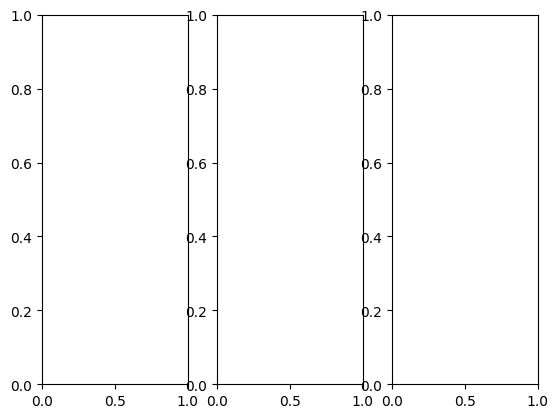

In [34]:
for t in timesteps_to_examine:
    # mean and cov for the simulated model
    q_t = tok_stats_sim[:,t,:] @ W_q.T
    q_sim_mean_t = torch.mean(q_t, dim=0)
    q_sim_cov_t = torch.cov(q_t.T)

    # Add small perturbation to the covariance matrix to force it being positive definite
    diag = torch.diag(torch.ones(num_patterns, num_patterns), diagonal=0) * 10**(-5)
    q_sim_cov_t += diag

    # # Same for the simulation from the previous MF calculations
    # q_t_m4 = tok_stats_sim_m4[:,t,:] @ W_q.T
    # q_sim_mean_t_m4 = torch.mean(q_t_m4, dim=0)
    # q_sim_cov_t_m4 = torch.cov(q_t_m4.T)
    #
    # # Add small perturbation to the covariance matrix to force it being positive definite
    # q_sim_cov_t_m4 += diag


    print("t", t)
    print("q sim", q_sim_mean_t)
    print("q mf", q_mf_t[t])
    print("q sim cov", q_sim_cov_t)
    print("q mf cov", q_mf_cov_t[t])

    # Grid config
    num_elems_grid = 2000
    if t == 0:
        grid_width = 0.005
    elif t == 2:
        grid_width = 0.5
    else:
        grid_width = 2
    grid = torch.linspace(-grid_width, grid_width, num_elems_grid)  # adjust range if mean is far from 0


    # Plot
    fig, axes = plt.subplots(1, 3)

    for i in range(3):

        dist_sim = torch.distributions.Normal(loc=q_sim_mean_t[i], scale=q_sim_cov_t[i,i])

        # dist_sim_mf_m4 = torch.distributions.Normal(loc=q_sim_mean_t_m4[i], scale=q_sim_cov_t_m4[i,i])


        # Distribution for the approximated model
        dist_mf = torch.distributions.Normal(loc=q_mf_t[t,i], scale=q_mf_cov_t[t,i,i])

        dist_mf_m3 = torch.distributions.Normal(loc=q_mf_t_m3[timesteps_to_examine[t],i], scale=q_mf_cov_t_m3[timesteps_to_examine[t],i,i])


        # Simulated model
        # Prepare input: all means, but vary the selected dimension
        x_sim = q_sim_mean_t[i] + grid #  vary selected dimension, center on mean

        logp_sim = dist_sim.log_prob(x_sim)
        p_sim = torch.exp(logp_sim).numpy()

        # # Simulated model from MF
        #
        # x_sim_mf_m4 = q_sim_mean_t_m4[i] + grid #  vary selected dimension, center on mean
        #
        # logp_sim_mf_m4 = dist_sim.log_prob(x_sim_mf_m4)
        # p_sim_mf_m4 = torch.exp(logp_sim_mf_m4).numpy()

        # Approximated model
        # Prepare input: all means, but vary the selected dimension
        x_mf = q_mf_t[t,i] + grid  # vary selected dimension, center on mean

        logp_mf = dist_mf.log_prob(x_mf)
        p_mf = torch.exp(logp_mf).numpy()

        x_mf_m3 = q_mf_t_m3[timesteps_to_examine[t], i] + grid  # vary selected dimension, center on mean

        logp_mf_m3 = dist_mf_m3.log_prob(x_mf_m3)
        p_mf_m3 = torch.exp(logp_mf_m3).numpy()


        axes[i].plot(x_sim, p_sim, label=f'Sim', color='steelblue')
        axes[i].plot(x_mf, p_mf, "--", label=f'MF', color='darkseagreen')
        axes[i].plot(x_mf_m3, p_mf_m3, "-.", label=f'MF (FS)', color='chocolate')
        # axes[i].plot(x_sim_mf_m4, p_sim_mf_m4, ":", label=f'Sim (MF)', color='mediumorchid')
        axes[i].set_title(f'Dim {i}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Density')

        if i == 0:
            axes[i].legend(loc="upper right")

    fig.suptitle(rf"Marginal Density t={timesteps_to_examine[t]} $\beta$={beta}")

    print()

### Compute error for different betas

beta = 0.0
Simulation. Time elapsed: 670.84 seconds
MF
MF from simulation stats
beta = 0.007352941203862429
Simulation. Time elapsed: 664.39 seconds
MF
MF from simulation stats
beta = 0.014705882407724857
Simulation. Time elapsed: 666.67 seconds
MF
MF from simulation stats
beta = 0.022058824077248573
Simulation. Time elapsed: 667.42 seconds
MF
MF from simulation stats
beta = 0.029411764815449715
Simulation. Time elapsed: 668.19 seconds
MF
MF from simulation stats
beta = 0.036764707416296005
Simulation. Time elapsed: 665.08 seconds
MF
MF from simulation stats
beta = 0.04411764815449715
Simulation. Time elapsed: 665.35 seconds
MF
MF from simulation stats
beta = 0.05147058889269829
Simulation. Time elapsed: 666.75 seconds
MF
MF from simulation stats
beta = 0.05882352963089943
Simulation. Time elapsed: 667.75 seconds
MF
MF from simulation stats
beta = 0.06617647409439087
Simulation. Time elapsed: 666.45 seconds
MF
MF from simulation stats
beta = 0.07352941483259201
Simulation. Time elapsed

Text(0.5, 1.0, 'token_size=750 n_trials=200000')

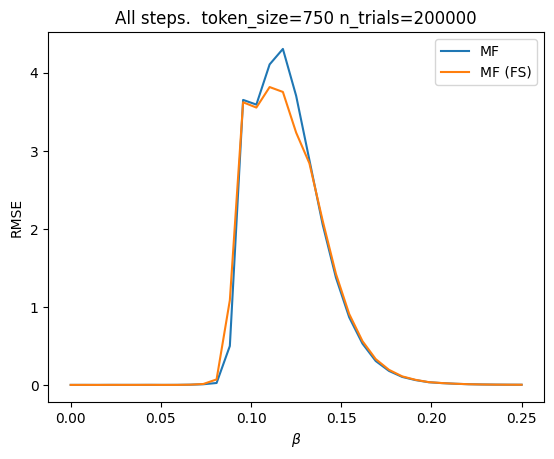

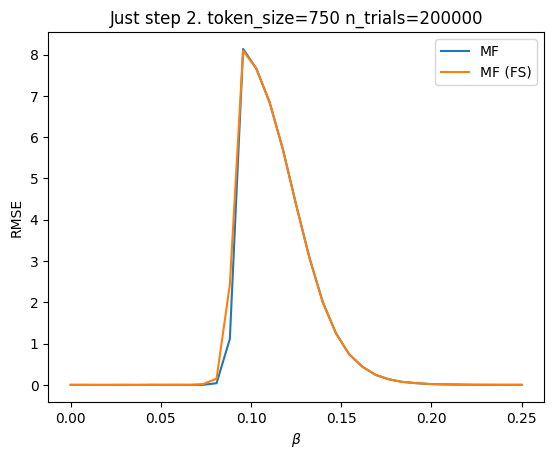

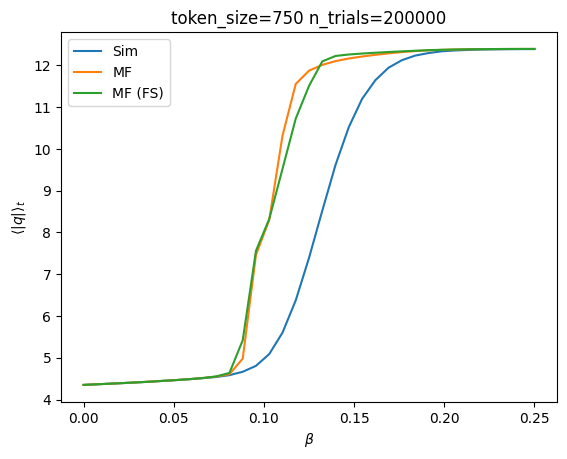

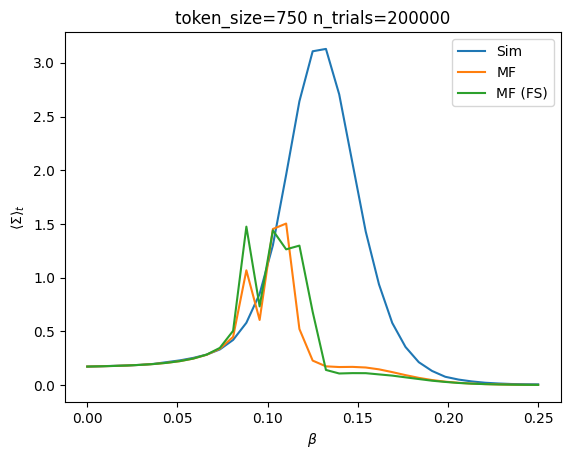

In [21]:
num_betas = 35
beta_list = torch.linspace(0, 0.25, num_betas)
# beta_list = [2.25, 2.5]

sim_mf_rmse = torch.zeros(len(beta_list))
sim_mf_sim_rmse = torch.zeros(len(beta_list))
sim_sim_mf_rmse = torch.zeros(len(beta_list))

timestep_to_examine = 2
sim_mf_rmse_step = torch.zeros(len(beta_list))
sim_mf_sim_rmse_step = torch.zeros(len(beta_list))
sim_sim_mf_rmse_step = torch.zeros(len(beta_list))

sim_norm_q_mean = torch.zeros(len(beta_list))
sim_mf_norm_q_mean = torch.zeros(len(beta_list))
sim_mf_sim_norm_q_mean = torch.zeros(len(beta_list))
sim_sim_mf_norm_q_mean = torch.zeros(len(beta_list))

sim_cov_q_mean = torch.zeros(len(beta_list))
sim_mf_cov_q_mean = torch.zeros(len(beta_list))
sim_mf_sim_cov_q_mean = torch.zeros(len(beta_list))
sim_sim_mf_cov_q_mean = torch.zeros(len(beta_list))

for b in range(len(beta_list)):
    # For each beta, compute the four methods

    print(f"beta = {beta_list[b]}")

    # Simulation
    tok_stats_sim, idxs, probs_sim_t_run, probs_sim_t_mean = simulate(beta_list[b])
    tok_stats_sim_avg = torch.mean(tok_stats_sim, dim=0)
    stats_k_sim = tok_stats_sim_avg @ W_k.T
    stats_q_sim = tok_stats_sim_avg @ W_q.T
    sim_norm_q_mean[b] = torch.mean(torch.norm(stats_q_sim, dim=1))
    sim_mean_q_centered = (tok_stats_sim @ W_q.T) - stats_q_sim
    sim_mean_q_centered = sim_mean_q_centered.transpose(0, 1) # shape: [T, N, M]
    sim_cov_q = torch.matmul(sim_mean_q_centered.transpose(1, 2), sim_mean_q_centered) / (num_trials - 1)  # shape: [T, M, M]# shape: [T, N, M]
    sim_cov_q_mean[b] = torch.mean(sim_cov_q)

    # Mean field
    stats_k_mf, idxs_mf, probs_mf_t, q_mf_t, q_mf_cov_t = simulate_mf(beta_list[b])
    sim_mf_norm_q_mean[b] = torch.mean(torch.norm(q_mf_t, dim=1))
    sim_mf_cov_q_mean[b] = torch.mean(q_mf_cov_t)


    # Mean field from the simulation stats
    stats_k_mf_m3, idxs_mf_m3, probs_mf_t_m3, q_mf_t_m3, q_mf_cov_t_m3 = simulate_mf_from_sim(tok_stats_sim, beta_list[b])
    sim_mf_sim_norm_q_mean[b] = torch.mean(torch.norm(q_mf_t_m3, dim=1))
    sim_mf_sim_cov_q_mean[b] = torch.mean(q_mf_cov_t_m3)

    # # Simulation from the mean-field experiment
    # tok_stats_sim_m4, idxs_m4, probs_sim_t_mean_m4 = simulate_sim_from_mf(q_mf_t, q_mf_cov_t, beta, diag_prod=10**-3)
    # tok_stats_sim_avg_m4 = torch.mean(tok_stats_sim_m4, dim=0)
    # stats_k_sim_m4 = tok_stats_sim_avg_m4 @ W_k.T

    sim_mf_rmse[b] =  torch.mean((stats_k_sim - stats_k_mf)**2)
    sim_mf_sim_rmse[b] =  torch.mean((stats_k_sim - stats_k_mf_m3)**2)
    # sim_sim_mf_rmse[b] =  torch.mean((stats_k_sim - stats_k_sim_m4)**2)

    sim_mf_rmse_step[b] =  torch.mean((stats_k_sim[timestep_to_examine] - stats_k_mf[timestep_to_examine])**2)
    sim_mf_sim_rmse_step[b] =  torch.mean((stats_k_sim[timestep_to_examine] - stats_k_mf_m3[timestep_to_examine])**2)
    # sim_sim_mf_rmse_step[b] =  torch.mean((stats_k_sim[timestep_to_examine] - stats_k_sim_m4[timestep_to_examine])**2)

# Compute the square
sim_mf_rmse = torch.sqrt(sim_mf_rmse)
sim_mf_sim_rmse = torch.sqrt(sim_mf_sim_rmse)
# sim_sim_mf_rmse = torch.sqrt(sim_sim_mf_rmse)

sim_mf_rmse_step = torch.sqrt(sim_mf_rmse_step)
sim_mf_sim_rmse_step = torch.sqrt(sim_mf_sim_rmse_step)
# sim_sim_mf_rmse_step = torch.sqrt(sim_sim_mf_rmse_step)

plt.figure()
plt.plot(beta_list, sim_mf_rmse, label='MF')
plt.plot(beta_list, sim_mf_sim_rmse, label='MF (FS)')
plt.legend()
# plt.plot(beta_list, sim_sim_mf_rmse, label='Sim (MF)')
plt.ylabel('RMSE')
plt.xlabel(r'$\beta$')
plt.title(f"All steps.  token_size={token_size} n_trials={num_trials}")


plt.figure()
plt.plot(beta_list, sim_mf_rmse_step, label='MF')
plt.plot(beta_list, sim_mf_sim_rmse_step, label='MF (FS)')
plt.legend()
# plt.plot(beta_list, sim_sim_mf_rmse, label='Sim (MF)')
plt.ylabel('RMSE')
plt.xlabel(r'$\beta$')
plt.title(f"Just step {timestep_to_examine}. token_size={token_size} n_trials={num_trials}")

fig = plt.figure()
plt.plot(beta_list, sim_norm_q_mean, label="Sim")
plt.plot(beta_list, sim_mf_norm_q_mean, label="MF")
plt.plot(beta_list, sim_mf_sim_norm_q_mean, label="MF (FS)")
plt.ylabel(fr"$\langle |q| \rangle_t$")
plt.xlabel(r'$\beta$')
plt.legend()
plt.title(f"token_size={token_size} n_trials={num_trials}")


fig = plt.figure()
plt.plot(beta_list, sim_cov_q_mean, label="Sim")
plt.plot(beta_list, sim_mf_cov_q_mean, label="MF")
plt.plot(beta_list, sim_mf_sim_cov_q_mean, label="MF (FS)")
plt.ylabel(fr"$\langle \Sigma \rangle_t$")
plt.xlabel(r'$\beta$')
plt.legend()
plt.title(f"token_size={token_size} n_trials={num_trials}")



In [72]:
sim_cov_q_mean

tensor([3.9759e-05, 3.9759e-05, 3.9759e-05, 3.9759e-05, 3.9759e-05, 3.9759e-05,
        3.9759e-05, 3.9759e-05, 3.9759e-05, 3.9759e-05, 3.9759e-05, 3.9759e-05,
        3.9759e-05, 3.9759e-05, 3.9759e-05, 3.9759e-05, 3.9759e-05, 3.9759e-05,
        3.9759e-05, 3.9759e-05, 3.9759e-05, 3.9759e-05, 3.9759e-05, 3.9759e-05,
        3.9759e-05, 3.9759e-05, 3.9759e-05, 3.9759e-05, 3.9759e-05, 3.9759e-05])

In [76]:
torch.mean(sim_cov_q)

tensor(3.9759e-05)

In [47]:
q_mf_cov_t

tensor([[[ 5.6843e-14,  3.9193e-33,  2.8422e-14],
         [ 3.9193e-33,  5.3222e-33,  1.3623e-33],
         [ 2.8422e-14,  1.3623e-33,  1.4211e-14]],

        [[ 2.0589e-03, -1.7261e-03,  2.5418e-03],
         [-1.7261e-03,  1.4472e-03, -2.1310e-03],
         [ 2.5418e-03, -2.1310e-03,  3.1379e-03]],

        [[ 2.3577e-03, -1.9767e-03,  2.9107e-03],
         [-1.9767e-03,  1.6572e-03, -2.4403e-03],
         [ 2.9107e-03, -2.4403e-03,  3.5934e-03]],

        [[ 5.6215e-04, -4.7130e-04,  6.9400e-04],
         [-4.7130e-04,  3.9513e-04, -5.8184e-04],
         [ 6.9400e-04, -5.8184e-04,  8.5679e-04]],

        [[ 4.7805e-04, -4.0079e-04,  5.9018e-04],
         [-4.0079e-04,  3.3601e-04, -4.9480e-04],
         [ 5.9018e-04, -4.9480e-04,  7.2861e-04]]])

In [30]:
tok_stats_sim.shape

torch.Size([20000, 5, 500])

Show the conditional of the simulated and mf model for $q_t$

In [218]:
# %%skip
# for t in timesteps_to_examine:
#     # mean and cov for the simulated model
#     q_sim_mean_t = torch.mean(tok_stats_sim[:,t,:] @ W_q.T, dim=0)
#     q_sim_cov_t = torch.cov((tok_stats_sim[:,t,:] @ W_q.T).T)
#
#     # Add small perturbation to the covariance matrix to force it being positive definite
#     diag = torch.diag(torch.ones(num_patterns, num_patterns), diagonal=0) * 10**(-5)
#     q_sim_cov_t += diag
#
#     dist_sim = torch.distributions.MultivariateNormal(loc=q_sim_mean_t, covariance_matrix=q_sim_cov_t)
#
#     # Distribution for the approximated model
#     dist_mf = torch.distributions.MultivariateNormal(loc=q_mf_t[t], covariance_matrix=q_mf_cov_t[t])
#
#     print("t", t)
#     print("q sim", q_sim_mean_t)
#     print("q mf", q_mf_t[t])
#     print("q sim cov", q_sim_cov_t)
#     print("q mf cov", q_mf_cov_t[t])
#
#     # Grid config
#     num_elems_grid = 2000
#     if t == 0:
#         grid_width = 0.005
#     elif t == 2:
#         grid_width = 0.5
#     else:
#         grid_width = 2
#     grid = torch.linspace(-grid_width, grid_width, num_elems_grid)  # adjust range if mean is far from 0
#
#
#     # Plot
#     fig, axes = plt.subplots(1, 3)
#
#     for i in range(3):
#         # Simulated model
#         # Prepare input: all means, but vary the selected dimension
#         x_sim = q_sim_mean_t.repeat(len(grid), 1)  # shape: (grid_size, N)
#         x_sim[:, i] += grid             # vary selected dimension, center on mean
#
#         logp_sim = dist_sim.log_prob(x_sim)
#         p_sim = torch.exp(logp_sim).numpy()
#
#         # Approximated model
#         # Prepare input: all means, but vary the selected dimension
#         x_mf = q_mf_t[t].repeat(len(grid), 1)  # shape: (grid_size, N)
#         x_mf[:, i] += grid             # vary selected dimension, center on mean
#
#         logp_mf = dist_mf.log_prob(x_mf)
#         p_mf = torch.exp(logp_mf).numpy()
#
#         axes[i].plot(x_sim[:, i], p_sim, label=f'Sim', color='steelblue')
#         axes[i].plot(x_mf[:, i], p_mf, "--", label=f'MF', color='darkseagreen')
#         axes[i].set_title(f'Dim {i}')
#         axes[i].set_xlabel('Value')
#         axes[i].set_ylabel('Density')
#
#         if i == 0:
#             axes[i].legend(loc="upper right")
#
#     fig.suptitle(rf"Conditional Density t={timesteps_to_examine[t]} $\beta$={beta}")


In [219]:
t2 = 0
tok_stats_sim[:,t2,:] @ W_q.T

tensor([[0.3994, 0.2599, 0.5574],
        [0.3994, 0.2599, 0.5574],
        [0.3994, 0.2599, 0.5574],
        ...,
        [0.3994, 0.2599, 0.5574],
        [0.3994, 0.2599, 0.5574],
        [0.3994, 0.2599, 0.5574]])